# 10.7 Group 6 Project: Report
# Covid Data Analysis
Kevin Carlson, Steve Gonzales, Michael Rozier<p>
Information Management, University of Washington<p>
IMT 574 A Sp 25: Data Science II: Machine Learning<p>
Pramod Gupta<p>
June 6, 2025<p>

When the COVID-19 virus turned into a worldwide pandemic in early 2020, most hospitals around the world ceased elective surgeries to prevent further infection and reduce deaths. This was especially true in the months leading up to the first vaccine's widespread availability in early 2021. Hospital administrators and physicians needed to carefully choose when to resume and when to pause so as not to overwhelm their hospitals with even more patients.<p>
As data became increasingly available, hospitals turned to data scientists and analysts to help them predict when they might be able to reopen. Initially, these predictions were not very accurate. As more data became available and reliability increased, they could use the data to predict whether there would be a surge in infections or deaths.<p>
Using seroprevalence (does your blood contain a chemical that indicates you had the COVID virus or were vaccinated), case, death, demographics and vaccine data primarily from the US Centers for Disease Control (CDC), we will predict if COVID cases and deaths to know when we can open hospitals to elective surgery.<p>
We will answer the following questions:<p>
1. Were some states worse off than others? I.e., could we resume operations in one state, but not in another? Could we categorize the states into high, medium, and low risk categories?
2. Given the demographic, seroprevalence, and vaccine data, could we predict when deaths due to COVID would decline to an acceptable level?
3. Since we might not have enough data ~50 rows (1 per week), can we improve the model with data at a more granular level, down to the state?
4. What are the most powerful leading indicators for forecasting a surge in infections?

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import DecisionBoundaryDisplay

In [3]:
# Import Case, Death, Seoprevalence data to cluster the states
# Source: https://data.cdc.gov/National-Center-for-Health-Statistics/Provisional-COVID-19-death-counts-rates-and-percen/mpx5-t7tu/about_data
covid_data = pd.read_csv("death_sero.csv")
print("Dataset shape:", covid_data.shape)
covid_data_agg = covid_data.groupby('state').agg({
    'tot_cases': 'max',
    'tot_deaths': 'max', 
    'n_samples': 'mean',
    'n_infected': 'mean'
}).reset_index()
display(covid_data_agg.head(3))

Dataset shape: (10479, 6)


,state,tot_cases,tot_deaths,n_samples,n_infected
0,AK,297588.0,1468.0,28991.348718,1157.076923
1,AL,1659936.0,21138.0,66436.817766,1861.851064
2,AR,995043.0,13115.0,37584.462609,1326.706522


In [4]:
display(covid_data_agg[covid_data_agg.isna().any(axis=1)])

,state,tot_cases,tot_deaths,n_samples,n_infected
3,AS,8331.0,34.0,NaN,NaN
11,FSM,26453.0,64.0,NaN,NaN
13,GU,61642.0,415.0,NaN,NaN
28,MP,13886.0,44.0,NaN,NaN
39,NYC,3266726.0,45181.0,NaN,NaN
45,PW,6000.0,9.0,NaN,NaN
47,RMI,16081.0,17.0,NaN,NaN
54,VI,24994.0,131.0,NaN,NaN


In [5]:
# The minor outlying states and NYC have some but not all data, so we'll filter them out
covid_data_agg = covid_data_agg.dropna()
display(covid_data_agg[covid_data_agg.isna().any(axis=1)])

,state,tot_cases,tot_deaths,n_samples,n_infected


# Question 1 - Clustering by State

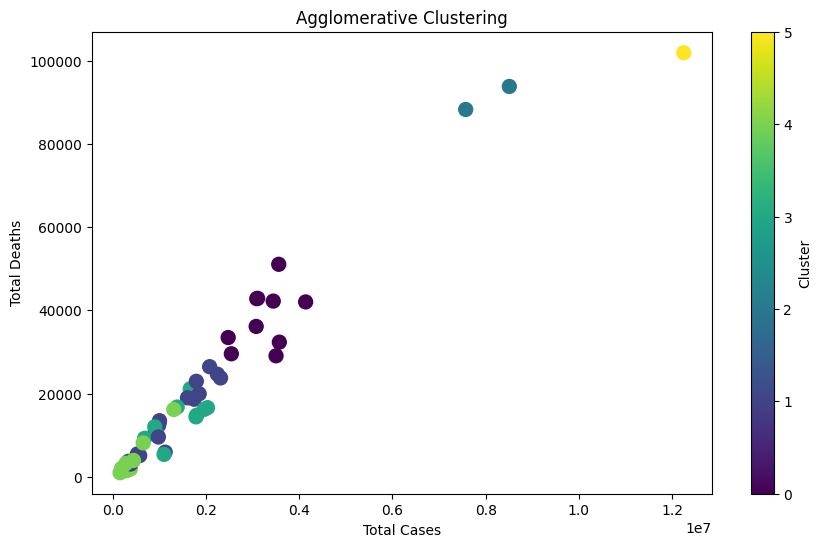

In [6]:
# Build Agglomerative Cluster to see which states are clustered together
covid_related = covid_data_agg[['tot_cases', 'tot_deaths', 'n_samples', 'n_infected']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(covid_related)
model = AgglomerativeClustering(n_clusters=6)
model.fit(scaled_features) 
# Scatterplot
x = covid_related['tot_cases']
y = covid_related['tot_deaths']
plt.figure(figsize=(10, 6))
plt.scatter(x, y, c=model.labels_, cmap='viridis', s=100)
plt.xlabel('Total Cases')
plt.ylabel('Total Deaths')
plt.title('Agglomerative Clustering')
plt.colorbar(label='Cluster')

## Question 1
We have 6 clusters, but three of them are not well separated at all. We'll do a Dendogram to see if we get better clustering. But first, let's look at trying different number of clusters.

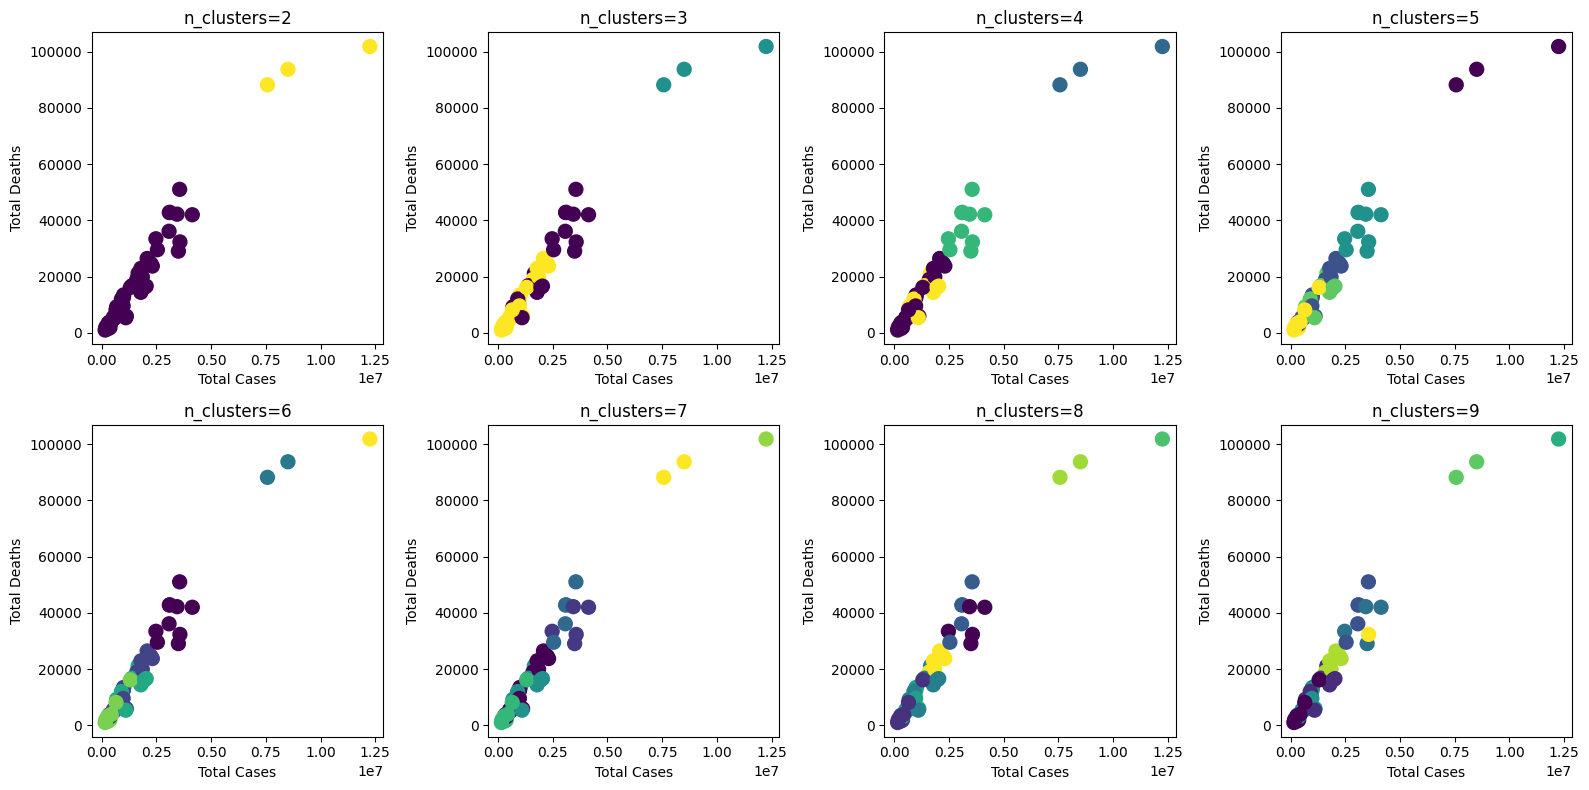

In [7]:
# Create a grid of scatter plots
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, n_clusters in enumerate(range(2, 10)):
    model = AgglomerativeClustering(n_clusters=n_clusters)
    model.fit(scaled_features)
    
    # Scatter plot
    x = covid_related['tot_cases']
    y = covid_related['tot_deaths']
    axes[i].scatter(x, y, c=model.labels_, cmap='viridis', s=100)
    axes[i].set_title(f'n_clusters={n_clusters}')
    axes[i].set_xlabel('Total Cases')
    axes[i].set_ylabel('Total Deaths')

plt.tight_layout()
plt.show()

## Question 1 continued
Two clusters are well defined, but very skewed with one cluster only having three states. All of the rest of the clusters do have good enough distinctions for cases and deaths.

Agglomerative Clustering Silhouette Score: 0.3784315824054109


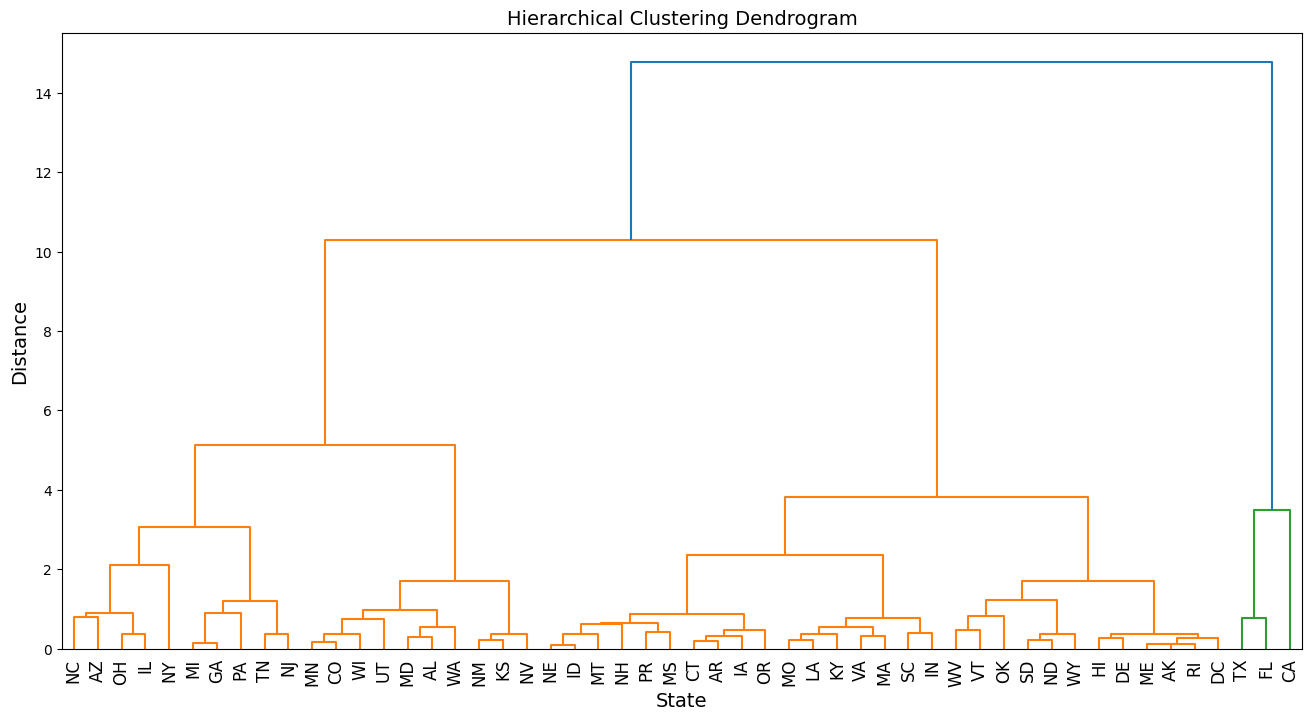

In [8]:
# Dendrogram
linked = linkage(scaled_features, method='ward')
plt.figure(figsize=(16, 8))
dendrogram(linked,
           labels=covid_data_agg['state'].values,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True,
           leaf_font_size=12)
plt.title('Hierarchical Clustering Dendrogram', fontsize=14)
plt.xlabel('State', fontsize=14)
plt.ylabel('Distance', fontsize=14)
plt.xticks(rotation=90)
# Calculate silhouette score
score = silhouette_score(scaled_features, model.labels_)
print("Agglomerative Clustering Silhouette Score:", score)

## Question 1 continued
These two clustering techniques do not seem to be clustering the data correctly. For example, we see TX, FL and CA all in the same cluster, but if we look at the individual data, cases & deaths, there are very stark differences:
 - Policy Differences: California enacted stricter measures like mandatory mask policies and stay-at-home orders, while Florida adopted a more laissez-faire approach, opting for optional mask mandates and quicker school reopenings.
 - Vaccination Rates: California had better-than-average vaccination rates, which experts say contributed to managing surges like the Delta variant wave. Florida had a higher percentage of fully vaccinated adults in non-medical settings (88.1%) compared to the median of 77.2% nationally.
 - Underlying Health Conditions: Studies have suggested that accounting for age and health factors like obesity and diabetes can impact the comparison of death rates between states. Some analyses indicated that when adjusting for these factors, Florida's age-adjusted mortality rate was only slightly higher than California's, or even ranked better when considering the health of the population.
 - Demographics and Overcrowding: The pandemic highlighted vulnerabilities in overcrowded settings, which was a significant factor in California, particularly in Los Angeles County, where more homes are overcrowded than in other large U.S. counties.<p>
<p> <p>
Reference: <i>Browne, E. (2021, November 11). California, with strict mandates, has more COVID cases than Florida, Texas—Here’s why. Newsweek. https://www.newsweek.com/california-strict-mandates-more-covid-cases-florida-texas-why-1648430</i>

In [9]:
filtered_df = covid_data_agg[covid_data_agg["state"].isin(["CA", "FL", "TX"])]
filtered_df.head()

,state,tot_cases,tot_deaths,n_samples,n_infected
5,CA,12251820.0,101886.0,148665.085851,3738.127660
10,FL,7572282.0,88248.0,97133.773478,2771.826087
51,TX,8508204.0,93780.0,112830.843805,2751.478261


In [10]:
# Extract and isolate Population by State
# Source: https://data.cdc.gov/Laboratory-Surveillance/Nationwide-Commercial-Laboratory-Seroprevalence-Su/d2tw-32xv/about_data
nat_sero_pop = pd.read_csv("Nationwide_Commercial_Laboratory_Seroprevalence_Survey.csv")
nat_sero_pop.rename(columns={'Site': 'state', 'Catchment population': 'state_population'}, inplace=True)
# There are aggregates in the data, like nationwide, filter them out
nat_sero_pop = nat_sero_pop[nat_sero_pop["Catchment Area Description"] == 'Statewide']
state_pop = nat_sero_pop.groupby('state')['state_population'].mean().reset_index()
display(state_pop.head(3))
# Add in state_population so we can do rates per 100K etc
covid_data = covid_data.merge(state_pop, on='state', how='left')
covid_data_agg = covid_data.groupby('state').agg({
    'state_population': 'max',
    'tot_cases': 'max',
    'tot_deaths': 'max', 
    'n_samples': 'mean',
    'n_infected': 'mean'
}).reset_index()
display(covid_data_agg.head(3))


,state,state_population
0,AK,6.578534e+05
1,AL,4.321031e+06
2,AR,2.660818e+06


,state,state_population,tot_cases,tot_deaths,n_samples,n_infected
0,AK,6.578534e+05,297588.0,1468.0,28991.348718,1157.076923
1,AL,4.321031e+06,1659936.0,21138.0,66436.817766,1861.851064
2,AR,2.660818e+06,995043.0,13115.0,37584.462609,1326.706522


## Question 1 continued
California has twice the population of Florida, yet, they have the total number of deaths that is about the same. Obviously, we need to factor in population so that the raw numbers are not hiding any details or skewing results.

In [11]:
# Helper function to calculate percapita data
def create_percapita(df, target_col_name, numerator_col_name, denominator_col_name = 'state_population'):
    df.loc[:, target_col_name] = np.where(
    df[denominator_col_name] > 0,
    (df[numerator_col_name] / df[denominator_col_name]) * 100000, 0)
    return df

In [12]:
covid_data_agg = create_percapita(covid_data_agg, 'cases_per_100k', 'tot_cases', 'state_population')
covid_data_agg = create_percapita(covid_data_agg, 'deaths_per_100k', 'tot_deaths', 'state_population')
covid_data_agg = create_percapita(covid_data_agg, 'case_fatality_rate', 'tot_deaths', 'tot_cases')
covid_data_agg = create_percapita(covid_data_agg, 'infection_rate', 'n_infected', 'n_samples')
covid_data_agg.head(3)

,state,state_population,tot_cases,tot_deaths,n_samples,n_infected,cases_per_100k,deaths_per_100k,case_fatality_rate,infection_rate
0,AK,6.578534e+05,297588.0,1468.0,28991.348718,1157.076923,45236.216317,223.150011,493.299461,3991.111053
1,AL,4.321031e+06,1659936.0,21138.0,66436.817766,1861.851064,38415.273814,489.188775,1273.422590,2802.438657
2,AR,2.660818e+06,995043.0,13115.0,37584.462609,1326.706522,37396.137589,492.893618,1318.033492,3529.933461


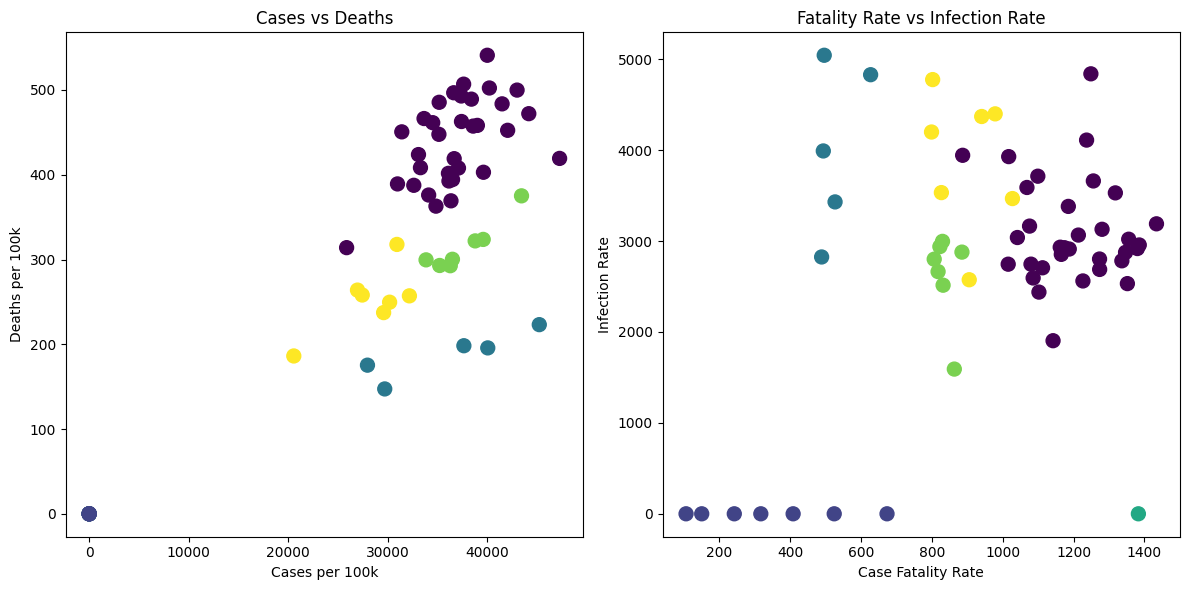

In [13]:
# Display Scatter Plot with percapita data to see if clusters are mode defined
covid_related = covid_data_agg[['cases_per_100k', 'deaths_per_100k', 'case_fatality_rate', 'infection_rate']]
# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(covid_related)

# Fit the clustering model
model = AgglomerativeClustering(n_clusters=6)
model.fit(scaled_features)

# Scatter plot data
x1 = covid_data_agg['cases_per_100k']
y1 = covid_data_agg['deaths_per_100k']
x2 = covid_data_agg['case_fatality_rate']
y2 = covid_data_agg['infection_rate']

# Create side-by-side scatter plots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# First scatter plot: Cases vs Deaths
axes[0].scatter(x1, y1, c=model.labels_, cmap='viridis', s=100)
axes[0].set_xlabel('Cases per 100k')
axes[0].set_ylabel('Deaths per 100k')
axes[0].set_title('Cases vs Deaths')

# Second scatter plot: Fatality Rate vs Infection Rate
axes[1].scatter(x2, y2, c=model.labels_, cmap='viridis', s=100)
axes[1].set_xlabel('Case Fatality Rate')
axes[1].set_ylabel('Infection Rate')
axes[1].set_title('Fatality Rate vs Infection Rate')

plt.tight_layout()
plt.show()

## Question 1 continued
Now Cases and Deaths are nicely clustered. The Fatality & Infection rate clusters are separated, but not as good as Cases & Deaths. With this clustering scheme, we have nice clusters, e.g. 1 to 5 or very low to very high.

Agglomerative Clustering Silhouette Score: 0.3898519619146974


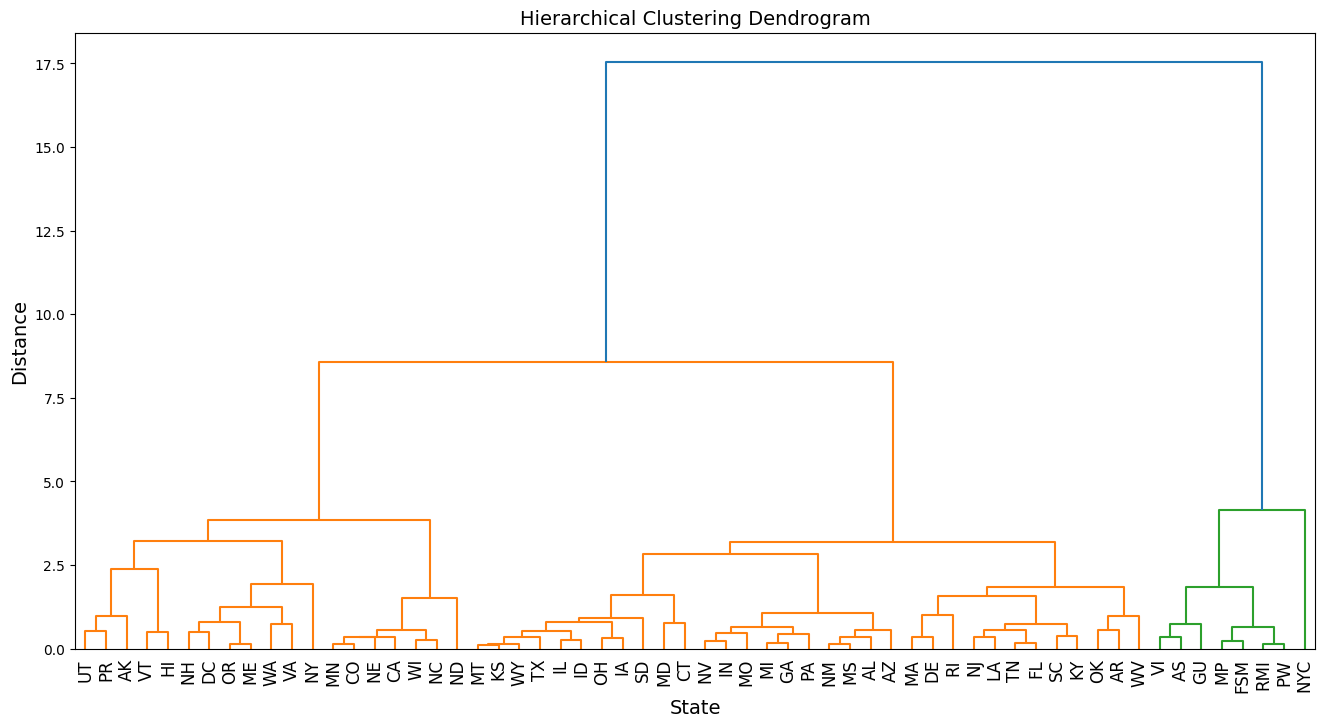

In [14]:
# Dendrogram with percapita features
linked = linkage(scaled_features, method='ward')
plt.figure(figsize=(16, 8))
dendrogram(linked,
           labels=covid_data_agg['state'].values,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True,
           leaf_font_size=12)
plt.title('Hierarchical Clustering Dendrogram', fontsize=14)
plt.xlabel('State', fontsize=14)
plt.ylabel('Distance', fontsize=14)
plt.xticks(rotation=90)
# Calculate silhouette score
score = silhouette_score(scaled_features, model.labels_)
print("Agglomerative Clustering Silhouette Score:", score)

## Question 1 - Summary and Answer
### Theoretical Explanation
We used unsupervised learning techniques here to see where the natural data separation lies. We let the data tell us what the clusters are. Unlike supervised learning, where we train models using labeled outcomes (e.g., whether a week was “unacceptable” or not), unsupervised learning has no predefined labels. Instead, it allows the data itself to guide the discovery of hidden patterns or clusters that may reveal underlying similarities, differences, or groupings.
This approach is especially useful when:
 - We want to validate whether the labeled outcomes align with natural groupings in the data.
 - We’re exploring the dataset in a hypothesis-free manner.
 - We suspect that latent structure (e.g., vaccine effectiveness patterns or state-level trends) exists beyond what traditional labels capture.

### Practical Explanation
This type of clustering will allow some states to share techniques and resources with other states that are in similar situations. The Federal Government could also use the clustering to allocate funds to those states that have more needs.
    
### Cluster Observations
Now we see CA with states like Minnesota, Colorado and North Carolina which had similar policies in place at the time. This clustering makes much more sense than the first one.<p>
The initial clustering was flawed due to population skew. After adjusting for per capita rates, clusters aligned better with known policy and outcome similarities (e.g., CA grouped with MN and CO). This confirmed that population-normalized metrics are essential for public health comparisons.<p>
Some states continued to emerge in high-risk clusters. This would indicate that additional funding, resources, education is required in these states to mitigate the negative effects of COVID.

# Question 2
Given the demographic, seroprevalence, and vaccine data, could we predict when deaths due to COVID would decline to an acceptable level?<p>

We need to come up with a benchmark for what constitutes unnacceptable. Since we are trying to determine if hospitals are being overwhelmed, we will focus on cases and not deaths. We will use South Korea and Germany as benchmarks since they had one of the fewest death rates of any country throughout the pandemic. However, we will have to increase the threshold because the US was much worse than South Korea; if \<500 per 100K weekly case rate was good for South Korea, we will have to multiply the US rate by 10 to get 5,000.<p>

Reference: <i>Choi, O., & Kim, S. (2024). Comparison of the efficacy of COVID-19 responses in South Korea and the United States. Global Health Action, 17(1). https://doi.org/10.1080/16549716.2024.2370611</i>

In [15]:
# Get detailed data set
# Source: https://ourworldindata.org/covid-cases
world_data = pd.read_csv('daily-new-confirmed-covid-19-cases-per-million-people.csv')
world_data.columns = ['country', 'date', 'new_cases_perM']
world_data['date'] = pd.to_datetime(world_data['date'])
world_data['year_week'] = world_data['year_week'] = world_data['date'].dt.strftime('%Y-W%U')
world_data['cases_per100K'] = world_data['new_cases_perM'] * 10
filtered_df = world_data[world_data["country"].isin(["South Korea", "United States", "Germany"])]
filtered_df = filtered_df.drop(['date'], axis=1)
filtered_df = filtered_df[filtered_df['cases_per100K'] > 0].drop_duplicates()
display(filtered_df.head(3))

,country,new_cases_perM,year_week,cases_per100K
159213,Germany,0.001982,2020-W01,0.019821
159214,Germany,0.001699,2020-W01,0.016989
159230,Germany,0.001699,2020-W04,0.016989


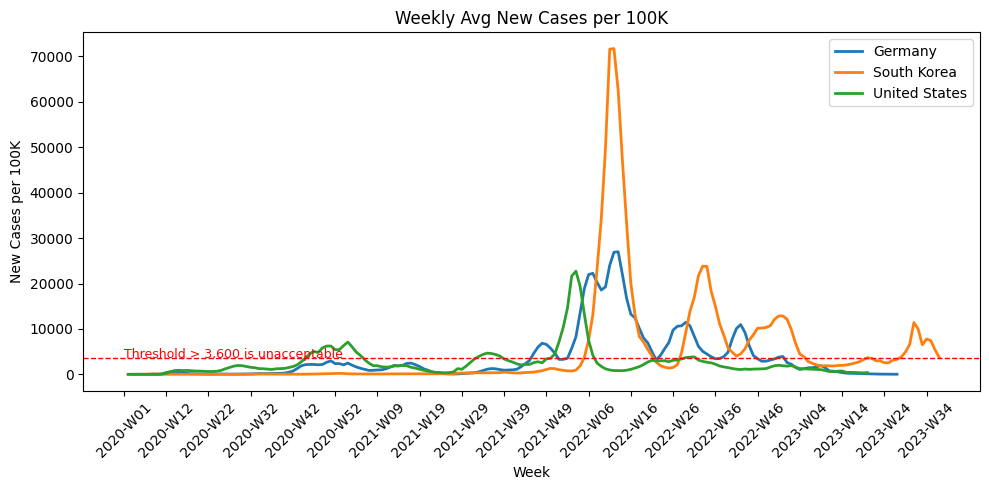

In [16]:
# Plot
pivot_df = filtered_df.pivot_table(index='year_week', columns='country', values='cases_per100K')
plt.figure(figsize=(10, 5))
plt.plot(pivot_df.index, pivot_df['Germany'], label='Germany', linewidth=2)
plt.plot(pivot_df.index, pivot_df['South Korea'], label='South Korea', linewidth=2)
plt.plot(pivot_df.index, pivot_df['United States'], label='United States', linewidth=2)

# Add threshold line
unacceptable_threshold = 3600
plt.axhline(y=unacceptable_threshold, color='red', linestyle='--', linewidth=1)
plt.text(pivot_df.index[0], unacceptable_threshold, f'Threshold > {unacceptable_threshold:,} is unacceptable', color='red', fontsize=9)

plt.title('Weekly Avg New Cases per 100K')
plt.xlabel('Week')
plt.ylabel('New Cases per 100K')
plt.legend()

# Rotate and skip x-ticks
xticks = pivot_df.index[::10]  # every other label
plt.xticks(ticks=xticks, labels=xticks, rotation=45)

plt.tight_layout()
plt.show()

Now let's build the model:
 - We have National Vaccine data by week `vaccine_data`
 - We have State level Death/Case by week `case_percapita`
 - Create an unacceptable flag cases per week

In [17]:
case_percapita = filtered_df.copy()
case_percapita = case_percapita[case_percapita["country"].isin(["United States"])].set_index('year_week')
vaccine_data = pd.read_csv('vaccine.csv').set_index('year_week')
case_percapita = case_percapita.drop(columns=['country'])
display(vaccine_data.head(2))
display(case_percapita.head(2))

,outcome,boosted_with_outcome,boosted_population,primary_series_only_with_outcome,primary_series_only_population,unvaccinated_with_outcome,unvaccinated_population,crude_booster_ir,crude_primary_series_only_ir,crude_unvax_ir,crude_booster_irr,crude_irr,age_adj_booster_ir,age_adj_vax_ir,age_adj_unvax_ir,age_adj_booster_irr,age_adj_irr
year_week,,,,,,,,,,,,,,,,,
2021-W38,case,546,1562854,107943,111647895,240670,49474362.8,34.936085,96.681626,486.453966,13.924112,5.031504,37.618216,97.743583,487.492642,12.958952,4.987464
2021-W39,case,624,1898762,102107,112762094,204700,48423938.8,32.863518,90.550819,422.724803,12.863042,4.668371,37.710445,91.303257,426.371625,11.306460,4.669840


,new_cases_perM,cases_per100K
year_week,,
2020-W03,0.000418,0.004183
2020-W03,0.002510,0.025097


In [18]:
# Merge data frames
case_vaccine = pd.merge(case_percapita, vaccine_data, on = 'year_week', how = 'outer')
case_vaccine = case_vaccine.dropna()
case_vaccine = case_vaccine.replace([None, np.nan, np.inf, -np.inf], 0)
display(case_vaccine.head(3))

,new_cases_perM,cases_per100K,outcome,boosted_with_outcome,boosted_population,primary_series_only_with_outcome,primary_series_only_population,unvaccinated_with_outcome,unvaccinated_population,crude_booster_ir,crude_primary_series_only_ir,crude_unvax_ir,crude_booster_irr,crude_irr,age_adj_booster_ir,age_adj_vax_ir,age_adj_unvax_ir,age_adj_booster_irr,age_adj_irr
year_week,,,,,,,,,,,,,,,,,,,
2021-W38,433.94717,4339.4717,case,546.0,1562854.0,107943.0,111647895.0,240670.0,49474362.8,34.936085,96.681626,486.453966,13.924112,5.031504,37.618216,97.743583,487.492642,12.958952,4.987464
2021-W38,433.94717,4339.4717,death,20.0,1496531.0,1278.0,105320742.0,4505.0,47581564.8,1.336424,1.213436,9.467953,7.084542,7.802596,0.477717,0.840807,12.932078,27.070573,15.380552
2021-W38,420.99344,4209.9344,case,546.0,1562854.0,107943.0,111647895.0,240670.0,49474362.8,34.936085,96.681626,486.453966,13.924112,5.031504,37.618216,97.743583,487.492642,12.958952,4.987464


In [19]:
# Compute weekly aggregates, drop anything that is not per 100K or a rate
case_vaccine_agg = case_vaccine.groupby(['year_week']).agg({
    'age_adj_booster_ir': 'sum',
    'age_adj_booster_irr': 'sum',
    'age_adj_irr': 'sum',
    'age_adj_vax_ir': 'sum',
    'crude_booster_ir': 'sum',
    'crude_booster_irr': 'sum',
    'crude_irr': 'sum',
    'crude_primary_series_only_ir': 'sum',
    'crude_unvax_ir': 'sum',
    'cases_per100K': 'max'
}).reset_index().set_index('year_week')
display(case_vaccine_agg.head(2))
case_vaccine_agg.describe()

,age_adj_booster_ir,age_adj_booster_irr,age_adj_irr,age_adj_vax_ir,crude_booster_ir,crude_booster_irr,crude_irr,crude_primary_series_only_ir,crude_unvax_ir,cases_per100K
year_week,,,,,,,,,,
2021-W38,266.671530,280.206671,142.576115,690.090734,253.907562,147.060581,89.83870,685.265434,3471.453430,4339.4717
2021-W39,269.595666,175.166952,140.366866,644.136702,239.291718,131.980914,86.56038,641.053333,3014.476397,3564.9830


,age_adj_booster_ir,age_adj_booster_irr,age_adj_irr,age_adj_vax_ir,crude_booster_ir,crude_booster_irr,crude_irr,crude_primary_series_only_ir,crude_unvax_ir,cases_per100K
count,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000
mean,1429.760414,152.483703,76.627254,1523.824817,1314.725813,67.439042,48.758182,1512.150949,3782.595401,4627.570588
std,1571.536692,133.897129,32.290058,2379.472286,1340.391560,65.136407,20.256589,2345.231120,5010.994578,5466.280871
min,160.646121,13.958513,22.636661,176.700909,146.034317,10.018596,17.849617,175.944799,485.765596,820.244700
25%,333.418468,55.212553,55.236206,541.306057,291.014329,19.470292,35.103278,539.354502,1652.176663,2255.546300
50%,1015.665446,102.115977,63.575263,744.214901,966.888628,37.517685,41.534646,738.889187,2378.887223,2938.163800
75%,1836.696898,175.364672,94.502784,1064.119763,1786.385559,122.083423,63.616470,1069.136346,2833.098231,3672.167400
max,8032.908330,540.866651,144.999632,12019.219266,6619.044685,227.201728,89.838700,11838.085666,24567.610995,23708.774000


In [20]:
case_vaccine_agg['unacceptable'] = (case_vaccine_agg['cases_per100K'] > unacceptable_threshold).astype(int)
print(case_vaccine_agg.shape)
display(case_vaccine_agg[case_vaccine_agg['cases_per100K'] > unacceptable_threshold].head(3))

(53, 11)


,age_adj_booster_ir,age_adj_booster_irr,age_adj_irr,age_adj_vax_ir,crude_booster_ir,crude_booster_irr,crude_irr,crude_primary_series_only_ir,crude_unvax_ir,cases_per100K,unacceptable
year_week,,,,,,,,,,,
2021-W38,266.671530,280.206671,142.576115,690.090734,253.907562,147.060581,89.838700,685.265434,3471.453430,4339.4717,1
2021-W49,333.418468,540.866651,124.993869,985.339407,259.038590,227.201728,83.458067,978.465240,3683.855934,3600.4282,1
2021-W50,1067.588465,379.312929,118.584344,1825.544997,684.076652,148.586882,79.616863,1764.741866,4959.616131,3672.1674,1


In [21]:
# Linear Regression Model
print("Linear Regression Model with aggregate data, not scaled")
x_cols = ['crude_booster_ir', 'crude_primary_series_only_ir', 'crude_unvax_ir',
          'crude_booster_irr', 'crude_irr', 'age_adj_booster_ir', 'age_adj_vax_ir', 
          'age_adj_booster_irr', 'age_adj_irr']

X = case_vaccine_agg[x_cols]
y = case_vaccine_agg['unacceptable']
# Split before scaling to prevent data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit the model
model_LR_noscale = LogisticRegression(max_iter=2500)
model_LR_noscale.fit(X_train, y_train)

# Predict and evaluate
y_pred = model_LR_noscale.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Linear Regression Model with aggregate data, not scaled
Accuracy: 0.9375
Confusion Matrix:
 [[11  0]
 [ 1  4]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96        11
           1       1.00      0.80      0.89         5

    accuracy                           0.94        16
   macro avg       0.96      0.90      0.92        16
weighted avg       0.94      0.94      0.94        16



In [22]:
# Try with StandardScaler
print("Linear Regression Model with aggregate data, StandardScaler")
x_cols = ['crude_booster_ir', 'crude_primary_series_only_ir', 'crude_unvax_ir',
          'crude_booster_irr', 'crude_irr', 'age_adj_booster_ir', 'age_adj_vax_ir', 
          'age_adj_booster_irr', 'age_adj_irr']

X = case_vaccine_agg[x_cols]
y = case_vaccine_agg['unacceptable']

# Split before scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit the model
model_LR_scaled = LogisticRegression(max_iter=2500)
model_LR_scaled.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred = model_LR_scaled.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Linear Regression Model with aggregate data, StandardScaler
Accuracy: 0.9375
Confusion Matrix:
 [[11  0]
 [ 1  4]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96        11
           1       1.00      0.80      0.89         5

    accuracy                           0.94        16
   macro avg       0.96      0.90      0.92        16
weighted avg       0.94      0.94      0.94        16



In [23]:
# Try with the RandomForest Classifier
print("RandomForest Classifier with aggregate data, not scaled")
# Features and target
x_cols = ['crude_booster_ir', 'crude_primary_series_only_ir', 'crude_unvax_ir',
          'crude_booster_irr', 'crude_irr', 'age_adj_booster_ir', 'age_adj_vax_ir', 
          'age_adj_booster_irr', 'age_adj_irr']

X = case_vaccine_agg[x_cols]
y = case_vaccine_agg['unacceptable']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit Random Forest
model_RF_noscale = RandomForestClassifier(n_estimators=100, random_state=42)
model_RF_noscale.fit(X_train, y_train)

# Predict and evaluate
y_pred = model_RF_noscale.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

RandomForest Classifier with aggregate data, not scaled
Accuracy: 1.0
Confusion Matrix:
 [[11  0]
 [ 0  5]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00         5

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16



In [24]:
#Try with the best subset of features
print("Linear Regression Model with best features, aggregate data, not scaled")
x_cols = ['crude_booster_ir', 'crude_primary_series_only_ir', 'crude_unvax_ir', 'crude_booster_irr', 'crude_irr', 'age_adj_booster_ir']

X = case_vaccine_agg[x_cols]
y = case_vaccine_agg['unacceptable']
# Split before scaling to prevent data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
model_LR_bestfeat = LogisticRegression(max_iter=2500)
model_LR_bestfeat.fit(X_train, y_train)

# Predict and evaluate
y_pred = model_LR_bestfeat.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Linear Regression Model with best features, aggregate data, not scaled
Accuracy: 1.0
Confusion Matrix:
 [[6 0]
 [0 5]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         5

    accuracy                           1.00        11
   macro avg       1.00      1.00      1.00        11
weighted avg       1.00      1.00      1.00        11



# Question 3 - Detailed Features
Try the detailed Vaccine data: keep age and vaccine brand break out

In [25]:
case_percapita

,new_cases_perM,cases_per100K
year_week,,
2020-W03,0.000418,0.004183
2020-W03,0.002510,0.025097
2020-W04,0.002928,0.029280
2020-W04,0.002510,0.025097
2020-W04,0.000837,0.008366
...,...,...
2023-W16,43.525055,435.250550
2023-W17,41.186863,411.868630
2023-W18,36.174603,361.746030


In [26]:
# Load the more detailed data that `vaccine.csv` was derived from
# Source: https://data.cdc.gov/Laboratory-Surveillance/2020-2021-Nationwide-Blood-Donor-Seroprevalence-Su/mtc3-kq6r/about_data
vaccine_detail_data = pd.read_csv('VaccineRates.csv')
# Week comes in like `YYYYWW`, convert it to `YYYY-WW`
vaccine_detail_data['year_week'] = vaccine_detail_data['mmwr_week'].astype(str).str[:4] + '-W' + vaccine_detail_data['mmwr_week'].astype(str).str[4:]
# Fix defects in the data
vaccine_detail_data['age_group'] = vaccine_detail_data['age_group'].replace('11-May', '5-11', regex=False)
vaccine_detail_data['age_group'] = vaccine_detail_data['age_group'].replace('17-Dec', '12-17', regex=False)
# DO NOT filter out all ages and types because the data is not all collected at these lower levels
# vaccine_detail_data = vaccine_detail_data[(vaccine_detail_data["age_group"] != "all_ages")]
# vaccine_detail_data = vaccine_detail_data[(vaccine_detail_data["vaccine_product"] != "all_types")]
vaccine_detail_data = vaccine_detail_data.drop(['month', 'mmwr_week', 'continuity_correction'], axis=1)
print(vaccine_detail_data.shape)
display(vaccine_detail_data.head(2))
print(sorted(vaccine_detail_data['year_week'].unique()))
# Join the two data sets
case_vaccine_detail = pd.merge(case_percapita, vaccine_detail_data, on = 'year_week', how = 'outer')
case_vaccine_detail = case_vaccine_detail.drop(['new_cases_perM'], axis=1) 
case_vaccine_detail = case_vaccine_detail.dropna()
case_vaccine_detail = case_vaccine_detail.replace([None, np.nan, np.inf, -np.inf], 0)
display(vaccine_detail_data.head(2))
print(case_vaccine_detail.columns)

(825, 20)


,outcome,age_group,vaccine_product,boosted_with_outcome,boosted_population,primary_series_only_with_outcome,primary_series_only_population,unvaccinated_with_outcome,unvaccinated_population,crude_booster_ir,crude_primary_series_only_ir,crude_unvax_ir,crude_booster_irr,crude_irr,age_adj_booster_ir,age_adj_vax_ir,age_adj_unvax_ir,age_adj_booster_irr,age_adj_irr,year_week
0,death,5-11,all_types,0,545135,0,4894771,1,12774055.0,0.0,0.0,0.007828,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-W30
1,death,12-17,all_types,0,2786599,0,7069903,0,6035472.0,0.0,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-W30


['2021-W38', '2021-W39', '2021-W40', '2021-W41', '2021-W42', '2021-W43', '2021-W44', '2021-W45', '2021-W46', '2021-W47', '2021-W48', '2021-W49', '2021-W50', '2021-W51', '2021-W52', '2022-W01', '2022-W02', '2022-W03', '2022-W04', '2022-W05', '2022-W06', '2022-W07', '2022-W08', '2022-W09', '2022-W10', '2022-W11', '2022-W12', '2022-W13', '2022-W14', '2022-W15', '2022-W16', '2022-W17', '2022-W18', '2022-W19', '2022-W20', '2022-W21', '2022-W22', '2022-W23', '2022-W24', '2022-W25', '2022-W26', '2022-W27', '2022-W28', '2022-W29', '2022-W30', '2022-W31', '2022-W32', '2022-W33', '2022-W34', '2022-W35', '2022-W36', '2022-W37', '2022-W38']


,outcome,age_group,vaccine_product,boosted_with_outcome,boosted_population,primary_series_only_with_outcome,primary_series_only_population,unvaccinated_with_outcome,unvaccinated_population,crude_booster_ir,crude_primary_series_only_ir,crude_unvax_ir,crude_booster_irr,crude_irr,age_adj_booster_ir,age_adj_vax_ir,age_adj_unvax_ir,age_adj_booster_irr,age_adj_irr,year_week
0,death,5-11,all_types,0,545135,0,4894771,1,12774055.0,0.0,0.0,0.007828,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-W30
1,death,12-17,all_types,0,2786599,0,7069903,0,6035472.0,0.0,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-W30


Index(['year_week', 'cases_per100K', 'outcome', 'age_group', 'vaccine_product',
       'boosted_with_outcome', 'boosted_population',
       'primary_series_only_with_outcome', 'primary_series_only_population',
       'unvaccinated_with_outcome', 'unvaccinated_population',
       'crude_booster_ir', 'crude_primary_series_only_ir', 'crude_unvax_ir',
       'crude_booster_irr', 'crude_irr', 'age_adj_booster_ir',
       'age_adj_vax_ir', 'age_adj_unvax_ir', 'age_adj_booster_irr',
       'age_adj_irr'],
      dtype='object')


In [27]:
# One hot encoding for categorical features
cat_cols = ['outcome', 'age_group', 'vaccine_product']
case_vaccine_detail_encoded = pd.get_dummies(case_vaccine_detail, columns=cat_cols, drop_first=True)
# Create the unacceptable col
case_vaccine_detail_encoded['unacceptable'] = (case_vaccine_detail_encoded['cases_per100K'] > unacceptable_threshold).astype(int)
print(case_vaccine_detail_encoded.columns)
display(case_vaccine_detail_encoded)

Index(['year_week', 'cases_per100K', 'boosted_with_outcome',
       'boosted_population', 'primary_series_only_with_outcome',
       'primary_series_only_population', 'unvaccinated_with_outcome',
       'unvaccinated_population', 'crude_booster_ir',
       'crude_primary_series_only_ir', 'crude_unvax_ir', 'crude_booster_irr',
       'crude_irr', 'age_adj_booster_ir', 'age_adj_vax_ir', 'age_adj_unvax_ir',
       'age_adj_booster_irr', 'age_adj_irr', 'outcome_death',
       'vaccine_product_Moderna', 'vaccine_product_Pfizer',
       'vaccine_product_all_types', 'unacceptable'],
      dtype='object')


,year_week,cases_per100K,boosted_with_outcome,boosted_population,primary_series_only_with_outcome,primary_series_only_population,unvaccinated_with_outcome,unvaccinated_population,crude_booster_ir,crude_primary_series_only_ir,...,age_adj_booster_ir,age_adj_vax_ir,age_adj_unvax_ir,age_adj_booster_irr,age_adj_irr,outcome_death,vaccine_product_Moderna,vaccine_product_Pfizer,vaccine_product_all_types,unacceptable
595,2021-W38,4339.4717,546.0,1562854.0,107943.0,111647895.0,240670.0,49474362.8,34.936085,96.681626,...,37.618216,97.743583,487.492642,12.958952,4.987464,False,False,False,True,1
596,2021-W38,4339.4717,7.0,28692.0,11003.0,9567298.0,240670.0,49474362.8,24.397044,115.006348,...,31.020156,114.456489,487.492642,15.715351,4.259196,False,False,False,False,1
597,2021-W38,4339.4717,202.0,685545.0,35197.0,44214235.0,240670.0,49474362.8,29.465608,79.605584,...,36.951175,81.632505,487.492642,13.192886,5.971796,False,True,False,False,1
598,2021-W38,4339.4717,334.0,843948.0,61644.0,57790888.0,240670.0,49474362.8,39.575898,106.667335,...,40.079402,106.631213,487.492642,12.163172,4.571763,False,False,True,False,1
602,2021-W38,4339.4717,20.0,1496531.0,1278.0,105320742.0,4505.0,47581564.8,1.336424,1.213436,...,0.477717,0.840807,12.932078,27.070573,15.380552,True,False,False,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6342,2022-W38,1569.6576,42479.0,41316940.0,25617.0,46028188.0,76751.0,52447237.8,102.812551,55.655026,...,93.932897,56.655500,188.173958,2.003281,3.321371,False,False,True,False,0
6348,2022-W38,1576.4964,76722.0,75035596.0,41805.0,76064165.0,76751.0,52447237.8,102.247472,54.960177,...,91.661394,54.482242,188.173958,2.052925,3.453859,False,False,False,True,0
6349,2022-W38,1576.4964,3356.0,4355939.0,3039.0,7043196.0,76751.0,52447237.8,77.044238,43.148025,...,60.690005,36.979177,188.173958,3.100576,5.088646,False,False,False,False,0
6350,2022-W38,1576.4964,30803.0,29301545.0,13088.0,22942002.0,76751.0,52447237.8,105.124150,57.048204,...,87.922209,55.520392,188.173958,2.140232,3.389276,False,True,False,False,0


In [28]:
# Linear Regression Model with Detailed Data, categorical features are 1Hot encoded
print("Linear Regression Model with detailed data, not scaled, categorical features 1Hot encoded")
x_cols_detail = ['boosted_with_outcome', 'boosted_population', 'primary_series_only_with_outcome',
          'primary_series_only_population', 'unvaccinated_with_outcome', 'unvaccinated_population', 
          'vaccine_product_Moderna', 'vaccine_product_Pfizer', 'vaccine_product_all_types',
          'crude_booster_ir', 'crude_primary_series_only_ir', 'crude_unvax_ir',
          'crude_booster_irr', 'crude_irr', 'age_adj_booster_ir', 'age_adj_vax_ir', 
          'age_adj_booster_irr', 'age_adj_irr']

X = case_vaccine_detail_encoded[x_cols_detail]
y = case_vaccine_detail_encoded['unacceptable']
# Split before scaling to prevent data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit the model
model_LR_noscale = LogisticRegression(max_iter=2500)
model_LR_noscale.fit(X_train, y_train)

# Predict and evaluate
y_pred = model_LR_noscale.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Linear Regression Model with detailed data, not scaled, categorical features 1Hot encoded
Accuracy: 0.8143360752056404
Confusion Matrix:
 [[644   6]
 [152  49]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.99      0.89       650
           1       0.89      0.24      0.38       201

    accuracy                           0.81       851
   macro avg       0.85      0.62      0.64       851
weighted avg       0.83      0.81      0.77       851



In [29]:
# Try with StandardScaler
print("Linear Regression Model with detailed data, Standard Scaler, categorical features 1Hot encoded")
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit the model
model_LR_scaled = LogisticRegression(max_iter=2500)
model_LR_scaled.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred = model_LR_scaled.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Linear Regression Model with detailed data, Standard Scaler, categorical features 1Hot encoded
Accuracy: 0.8061104582843713
Confusion Matrix:
 [[631  19]
 [146  55]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.97      0.88       650
           1       0.74      0.27      0.40       201

    accuracy                           0.81       851
   macro avg       0.78      0.62      0.64       851
weighted avg       0.80      0.81      0.77       851



In [30]:
# Try with Random Forest; all prior data setup applies
print("Random Forest Classifier with detailed data, not scaled, categorical features 1Hot encoded")
# Fit Random Forest
model_RF_detail = RandomForestClassifier(n_estimators=100, random_state=42)
model_RF_detail.fit(X_train, y_train)

# Predict and evaluate
y_pred = model_RF_detail.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Random Forest Classifier with detailed data, not scaled, categorical features 1Hot encoded
Accuracy: 0.981198589894242
Confusion Matrix:
 [[646   4]
 [ 12 189]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       650
           1       0.98      0.94      0.96       201

    accuracy                           0.98       851
   macro avg       0.98      0.97      0.97       851
weighted avg       0.98      0.98      0.98       851



In [31]:
x_cols_detail

['boosted_with_outcome',
 'boosted_population',
 'primary_series_only_with_outcome',
 'primary_series_only_population',
 'unvaccinated_with_outcome',
 'unvaccinated_population',
 'vaccine_product_Moderna',
 'vaccine_product_Pfizer',
 'vaccine_product_all_types',
 'crude_booster_ir',
 'crude_primary_series_only_ir',
 'crude_unvax_ir',
 'crude_booster_irr',
 'crude_irr',
 'age_adj_booster_ir',
 'age_adj_vax_ir',
 'age_adj_booster_irr',
 'age_adj_irr']

## Question 3 - Summary and Answer
### Defining Acceptable Risk Threshold
First we had to define an acceptable risk threshold. Since we were trying to predict when a hospital had the capacity to handle more patients, we used cases per 100K (as opposed to deaths, which could be used for a different business use case). We used South Korea and Germany as baselines for effective pandemic control. Although South Korea had an enourmous spike of cases in early 2022, this was due to political factors and once they got things under control, they resumed a mostly best practice mode of operation.<p>

We established 3,600+ weekly new cases per 100k as an “unacceptable” threshold for the US, adjusting for relative case rates.<p>

### Theortetical Explanation
#### Logistic Regression
Our analysis treats the problem of identifying whether weekly COVID-19 case rates are “unacceptable” as a binary classification task. The dependent variable is derived from whether the number of cases per 100K exceeds a predefined threshold (3,600+) based on international benchmarks.<p>
    
We use Logistic Regression as a baseline model due to its interpretability and strong performance on linearly separable datasets. Logistic regression models the probability that a given input belongs to a specific class using the logistic (sigmoid) function, which is appropriate for binary classification. Its coefficients provide insights into the direction and strength of each predictor’s impact on the target.<p>
    
#### Random Forest
However, we also use a Random Forest Classifier because real-world public health data often involves non-linear relationships and complex interactions between features (booster rate, variant virulence, age structure). This ensemble learning method builds multiple decision trees and aggregates their outputs, which reduces overfitting and effectively captures nonlinear patterns. It’s robust to irrelevant features, handles missing data gracefully, and is less sensitive to scaling.
 
Random Forests handle complex interactions between health metrics and behavioral data (i.e. vaccination rate + infection rate + case fatality rate), making it ideal for multifactor risk assessment in a dynamic, noisy public health environment.
    
### Predictive Modeling

#### Logistic Regression with Small Data set
We scaled the features with StandardScaler and ran through a number of scenarios with Logistic Regression models. We got accuracy rates in the range of 94% to 100% (when picking the best features). The 100% accuracy on a model processing <b>53 rows is likely overfit and should not be fully relied on for detailed decision making</b>.<p>
The Class 1 count is just 5. One false negative (predicted as unacceptable, but is actually acceptable, so care is unnessarily witheld) drops recall from `100% → 80%`, and F1 from `1.0 → 0.89`. That one mistake results in a <b>20% drop in recall</b>, simply because n=5. This clearly indicates that our sample set is very small and should not be relied on for large scale or critical predictions.<p>
    
#### Large Dataset and Best Model Results
So we then went to the base data that was used for the first models and kept all of the details like age groups, vaccine brands (Moderna, Janssen, Pfizer), and outcome of case. This provided us with a data set of almost 3,000 rows. We ran this data through the same models which produced much more reliable results.<p>

This data set retained all granular details—such as:
 - Age groups
 - Vaccine brand types (Moderna, Janssen, Pfizer)
 - Case outcomes
 - Weekly death/case rates
 - Demographic features like state population and seroprevalence

This allowed us to train a <b>Random Forest Classifier</b>, a non-parametric, ensemble-based model that handles nonlinear relationships, interaction effects, and categorical variables (via one-hot encoding) very well—without requiring feature scaling.<p>

Performance on a validation subset (851 samples) was very strong:
 - Accuracy: 98.1%
 - Precision (Class 1): 0.98
 - Recall (Class 1): 0.94
 - F1 Score (Class 1): 0.96
    
### Practical Explanation
Our model classifies regions or scenarios as either “acceptable” or “unacceptable”—which likely indicates a threshold of public health risk that warrants policy intervention. As explained earlier, this will help determine when to open hospitals to elective surgery. It could also have the following importation applications:<p>
 - Early Warning System for Policy Makers. Automatically flag geographic regions or population segments as “unacceptable” based on recent case trends, death rates, or vaccination gaps.
 - Helps allocate resources, testing, or vaccination drives preemptively.
 - Decision-Support for Restriction Tiers. Feed this model into a tiered policy framework (e.g., mask mandates, gathering restrictions). E.g., if a county is predicted as "unacceptable," trigger a shift to higher restriction level.
 - Health Equity Monitoring. Because the model uses features like sero rates, population, vaccine effectiveness, it could identify areas where healthcare delivery is failing or outcomes are inequitable. Useful for targeted interventions in vulnerable groups.
 - Public Dashboard Back-End. Serve predictions to a public dashboard showing “risk status” of different regions (e.g., green/yellow/red). Would provide transparency and support public understanding of outbreak dynamics.
 - Strategic Planning. Feed model outputs into supply chain models to prioritize delivery of PPE, antivirals, or personnel where they're most needed.

# Question 4 - Best Features
What are the best predictors for this model?

In [32]:
# Stepwise Feature Selection with Logistic Regression Model
x_cols_agg = ['crude_booster_ir', 'crude_primary_series_only_ir', 'crude_unvax_ir',
          'crude_booster_irr', 'crude_irr', 'age_adj_booster_ir', 'age_adj_vax_ir', 
          'age_adj_booster_irr', 'age_adj_irr']

cols_try = []
for i, col in enumerate(x_cols_agg):
    cols_try.append(col)
    print(cols_try)
    X = case_vaccine_agg[cols_try]
    y = case_vaccine_agg['unacceptable']
    # Split before scaling to prevent data leakage
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Fit the model
    model = LogisticRegression(max_iter=2500)
    model.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = model.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print('-'*80)

['crude_booster_ir']
Accuracy: 0.75
--------------------------------------------------------------------------------
['crude_booster_ir', 'crude_primary_series_only_ir']
Accuracy: 1.0
--------------------------------------------------------------------------------
['crude_booster_ir', 'crude_primary_series_only_ir', 'crude_unvax_ir']
Accuracy: 1.0
--------------------------------------------------------------------------------
['crude_booster_ir', 'crude_primary_series_only_ir', 'crude_unvax_ir', 'crude_booster_irr']
Accuracy: 1.0
--------------------------------------------------------------------------------
['crude_booster_ir', 'crude_primary_series_only_ir', 'crude_unvax_ir', 'crude_booster_irr', 'crude_irr']
Accuracy: 1.0
--------------------------------------------------------------------------------
['crude_booster_ir', 'crude_primary_series_only_ir', 'crude_unvax_ir', 'crude_booster_irr', 'crude_irr', 'age_adj_booster_ir']
Accuracy: 1.0
-----------------------------------------

In [33]:
# Feature Importance for Random Forest, no scaled, aggregate data
for i, fi in enumerate(model_RF_noscale.feature_importances_):
    if fi >= .15:
        print(f'{x_cols_agg[i]}: {fi:.3f} ** very good')
    else:
        print(f'{x_cols_agg[i]}: {fi:.3f}')

crude_booster_ir: 0.103
crude_primary_series_only_ir: 0.244 ** very good
crude_unvax_ir: 0.233 ** very good
crude_booster_irr: 0.077
crude_irr: 0.037
age_adj_booster_ir: 0.046
age_adj_vax_ir: 0.150 ** very good
age_adj_booster_irr: 0.073
age_adj_irr: 0.038


In [34]:
# Feature Importance for Random Forest model with Detailed data
for i, fi in enumerate(model_RF_detail.feature_importances_):
    print(f'{x_cols_detail[i]}: {fi:.3f}')

boosted_with_outcome: 0.029
boosted_population: 0.027
primary_series_only_with_outcome: 0.029
primary_series_only_population: 0.016
unvaccinated_with_outcome: 0.144
unvaccinated_population: 0.087
vaccine_product_Moderna: 0.001
vaccine_product_Pfizer: 0.000
vaccine_product_all_types: 0.000
crude_booster_ir: 0.086
crude_primary_series_only_ir: 0.101
crude_unvax_ir: 0.112
crude_booster_irr: 0.044
crude_irr: 0.028
age_adj_booster_ir: 0.101
age_adj_vax_ir: 0.089
age_adj_booster_irr: 0.059
age_adj_irr: 0.046


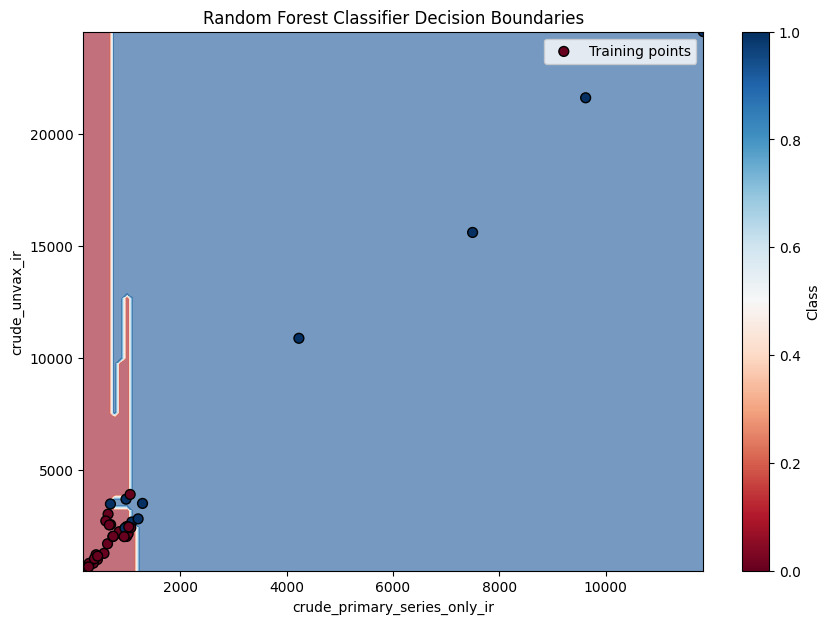

In [35]:
# Scatter Plot Decision Boundaries for the two best features
feature_1 = 'crude_primary_series_only_ir'
feature_2 = 'crude_unvax_ir'
X_df = pd.DataFrame(X, columns=[feature_1, feature_2])
y_series = pd.Series(y, name='unacceptable')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_df, y_series, test_size=0.3, random_state=42)

# Train a RandomForestClassifier
# n_estimators is the number of trees in the forest.
model_RF_detail = RandomForestClassifier(n_estimators=100, random_state=42)
model_RF_detail.fit(X_train, y_train)

# Create a figure and an axes object for the plot
fig, ax = plt.subplots(figsize=(10, 7))

# Plot the decision boundaries using DecisionBoundaryDisplay
# DecisionBoundaryDisplay.from_estimator is a convenient function from scikit-learn
# that plots the decision surface for a classifier.
DecisionBoundaryDisplay.from_estimator(
    model_RF_detail,  
    X_train,          # The data used to define the plotting range and class distribution
    cmap=plt.cm.RdBu, # Colormap for the decision regions
    alpha=0.6,        # Transparency of the decision regions
    ax=ax,            # The axes object to plot on
    plot_method="contourf", # Use filled contours for the regions
    response_method="predict" # Use the model's 'predict' method to determine class for each point
)

# Plot the actual training data points on top of the decision boundaries
scatter = ax.scatter(X_train[feature_1], X_train[feature_2], c=y_train, s=50, edgecolors='k',
                     cmap=plt.cm.RdBu, label="Training points")
# Add labels, title, and legend for clarity
ax.set_xlabel(feature_1)
ax.set_ylabel(feature_2)
ax.set_title("Random Forest Classifier Decision Boundaries")
ax.legend()
# Add a color bar to explain the class colors
plt.colorbar(scatter, ax=ax, label="Class")
plt.show()

### Decision Boundary for "best two" features
X-axis: crude_primary_series_only_ir: The incidence rate (e.g., new cases per 100k) for individuals who have completed only their primary vaccine series.<p>
Y-axis: crude_unvax_ir: New cases per 100k.<p>

#### Interpretation of the Scatter (Training) Points:

##### Dense Cluster in Bottom-Left:
The most striking feature is the heavy concentration of data points in the bottom-left corner of the plot. This indicates that a large majority of the training data (likely representing different time periods or regions) had relatively low incidence rates for both primary series vaccinated individuals and unvaccinated individuals.<p>
Within this dense cluster, we see points belonging to both classes (red and blue). This suggests that even at low incidence rates, there's a distinction being made by the model. The "red" points tend to be when both rates are very low, while "blue" points start appearing as either crude_unvax_ir or crude_primary_series_only_ir increase slightly from very low values.<p>

###### Sparse Points at Higher Incidence Rates:
As we move away from the bottom-left cluster towards higher values on either axis, the data points become very sparse.
Crucially, all the scattered points at higher incidence rates are colored blue. This implies that scenarios (time periods/regions) where either crude_primary_series_only_ir or crude_unvax_ir (or both) are significantly elevated consistently fall into the 'blue' class.<p>
    
###### Interpretation of the Decision Boundaries:
Dominant Blue Region: The vast majority of the plot area, particularly for higher values of both incidence rates, is colored blue. This clearly shows that the Random Forest model generally classifies scenarios with higher COVID-19 incidence rates (for either group) into the 'blue' category.<p>

Red Region for Low Incidence: The 'red' class (Class 0, assuming the color bar is 0=red, 1=blue) is primarily located in the bottom-left corner, corresponding to situations where both crude_primary_series_only_ir and crude_unvax_ir are low. This suggests that the 'red' class likely represents a "low-risk" or "favorable" state regarding COVID-19 transmission, where incidence rates are generally suppressed across these vaccination groups.<p>
    
#### Decision Boundary Summary
The model, based on these two features, largely segregates conditions into a "low incidence" (red) class and a "higher incidence" (blue) class. The 'red' class is tightly constrained to scenarios where both vaccinated and unvaccinated incidence rates are low. As either rate increases, the model quickly shifts its prediction to the 'blue' class. The complex, non-linear boundary, especially at lower incidence levels, reflects the Random Forest's ability to capture nuanced relationships within your COVID-19 data.

## Question 4 - Summary and Answer
### Stepwise Logistic Regression
In this section, we added predictors one by one (left to right) and evaluating model performance (accuracy) after each new feature is added.<p>
This method implicitly reveals which combinations of features begin to meaningfully improve the model’s ability to classify weeks as acceptable/unacceptable. Accuracy jumps are important — when a new column significantly increases accuracy, it’s a sign of strong predictive power.<p>
 - First few variables likely increased accuracy slowly (maybe from ~0.65 → ~0.73).
 - When we added variables like `crude_unvax_ir` or `age_adj_booster_ir`, the jump was larger — indicating they carry independent predictive signal. Diminishing returns likely occurred with later features like `crude_booster_irr` or `age_adj_irr`, meaning they are either redundant or have low predictive power.
    
### Feature Importance in Random Forest Models
These three features stood out as the best predictors:
1. `crude_unvax_ir` (Infection Rate Among Unvaccinated). Most important feature. Highly intuitive — areas with higher infection rates among the unvaccinated were more likely to experience case surges. Strongly associated with overall transmission pressure.
2. `age_adj_booster_ir` (Infection Rate Among Boosted, Age-Adjusted). Counterintuitively important. May indicate that breakthrough infections were common even in boosted populations, signaling widespread community transmission or emergence of new variants. Could also be picking up data quality biases — e.g., higher rates of testing in vaccinated populations.
3. `age_adj_vax_ir` (Infection Rate Among Fully Vaxxed, Age-Adjusted). Similar story to the booster rate above. Captures spread despite vaccination, perhaps reflecting policy looseness or variant presence.

What These Features Have in Common:
 - Directly measure outcomes, not just proxy behaviors (like rate ratios).
 - Age-adjustment improves signal by controlling for known confounder.
 - Crude rates are still powerful, especially among the unvaxxed.